In [1]:
%load_ext autoreload
%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

from benchmarking import *
% matplotlib inline

# import and format

In [2]:
mu = 4.0
theta = 2.0
dropout = 0.7
p = mu / (mu + theta)
r = theta 
shape_train = (2000, 10)
shape_test = (1000, 10)
l_train = np.random.gamma(r, p / (1-p), size=shape_train)
X_train = np.random.poisson(l_train)
l_test = np.random.gamma(r, p / (1-p), size=shape_test)
X_test = np.random.poisson(l_test)
X_train *= np.random.binomial(1, 1-dropout, size=shape_train)
X_test *= np.random.binomial(1, 1-dropout, size=shape_test)
c_train = np.zeros(shape_train[0])
print("mu "+ str(mu) +" theta "+ str(theta) +" r "+ str(r) +" p "+ str(p) +" dropout " + str(dropout))
print np.mean(np.sum(X_train, axis=1) == 0), np.mean(X_train == 0)
print c_train.shape

mu 4.0 theta 2.0 r 2.0 p 0.666666666667 dropout 0.7
0.0365 0.73385
(2000,)


In [3]:
c_train = c_train[np.sum(X_train, axis=1) > 0]
X_train = X_train[np.sum(X_train, axis=1) > 0]

In [4]:
from sklearn.decomposition import PCA
from sklearn.decomposition import FactorAnalysis
from ZIFA import ZIFA
from ZINB import ZINB
from SIMLR import SIMLR

In [5]:
n_latent = 10

In [6]:
simlr = SIMLR(n_clusters=10)
%time simlr.estimate_clusters_numbers(X_train)

CPU times: user 1min 57s, sys: 1.13 s, total: 1min 58s
Wall time: 2min 19s


In [7]:
simlr.estimated_clusters

array([ -386.61387572,    13.05188711,   -66.56781925,   163.49052791,
         -23.16064066,   -72.83891905,   227.93242805,  -416.21179019,
        1066.84052504,  -863.06716126,  -263.7840693 ,   -11.43103153,
         499.67635066,  -123.03235339,   207.43807168,    68.17955192,
        -409.27826546,   265.58324818,   -67.33563236])

In [8]:
simlr = SIMLR(n_clusters=11)
%time simlr.fit_transform(X_train)

Performing fast PCA.
Performing k-nearest neighbour search.
Computing the multiple Kernels.
Performing the iterative procedure  5  times.
Iteration:  1 
Iteration:  2 
Iteration:  3 
Iteration:  4 
Iteration:  5 
Performing Kmeans.
Performing t-SNE.
The main loop will be now performed with a maximum of 300 iterations.
Performing iteration 1.
Performing iteration 2.
Performing iteration 3.
Performing iteration 4.
Performing iteration 5.
Performing iteration 6.
Performing iteration 7.
Performing iteration 8.
Performing iteration 9.
Performing iteration 10.
Performing iteration 11.
Performing iteration 12.
Performing iteration 13.
Performing iteration 14.
Performing iteration 15.
Performing iteration 16.
Performing iteration 17.
Performing iteration 18.
Performing iteration 19.
Performing iteration 20.
Performing iteration 21.
Performing iteration 22.
Performing iteration 23.
Performing iteration 24.
Performing iteration 25.
Performing iteration 26.
Performing iteration 27.
Performing ite

SIMLR(n_clusters=11)

In [9]:
log_library_size = np.log(np.sum(X_train, axis=1))
zero_amount = np.sum(X_train == 0, axis=1)
mean, var = np.mean(log_library_size), np.var(log_library_size)

In [10]:
from model import scVI
import tensorflow as tf
import time
batch_size = 128
learning_rate = 0.001
epsilon = 0.01

log_library_size = np.log(np.sum(X_train, axis=1))
mean, var = np.mean(log_library_size), np.var(log_library_size)

tf.reset_default_graph()
expression = tf.placeholder(tf.float32, (None, X_train.shape[1]), name='x')
kl_scalar = tf.placeholder(tf.float32, (), name='kl_scalar')
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate, epsilon=epsilon)
training_phase = tf.placeholder(tf.bool, (), name='training_phase')

model = scVI.scVIModel(expression=expression, kl_scale=kl_scalar, \
                         optimize_algo=optimizer, phase=training_phase, \
                          library_size_mean=mean, library_size_var=var, \
                          n_latent=10)

# Session creation
sess = tf.Session()
sess.run(tf.global_variables_initializer())

def next_batch(data, batch_size):
    index = np.random.choice(np.arange(data.shape[0]), size=batch_size)
    return data[index].astype(np.float32)

def train_model(num_epochs, expression_train, expression_test, step):
    iterep = int(expression_train.shape[0]/float(batch_size))-1
    training_history = {"t_loss":[], "v_loss":[], "time":[], "epoch":[]}
    training_history["n_hidden"] = model.n_hidden
    training_history["model"] = model.__class__.__name__
    training_history["n_input"] = model.n_input
    training_history["dropout_nn"] = model.dropout_rate
    training_history["learning_rate"] = learning_rate
    training_history["dispersion"] = model.complex_dispersion
    training_history["epsilon"] = epsilon
    training_history["n_layers"] = model.n_layers
    begin = time.time()
    
    
    for t in range(iterep * num_epochs):
    
        # arange data in batches
        x_train = next_batch(X_train, batch_size)
        x_test = next_batch(X_test, batch_size)

        #prepare data dictionaries
        dic_train = {expression: x_train, training_phase:True, kl_scalar:1}
        dic_test = {expression: x_test, training_phase:False, kl_scalar:1} 

        # run an optimization set
        _, l_tr = sess.run([step, model.loss], feed_dict=dic_train)
        end_epoch, epoch = t % iterep == 0, t / iterep

        if end_epoch:
            now = time.time()
            print epoch

            l_t = sess.run((model.loss), feed_dict=dic_test)

            training_history["t_loss"].append(l_tr)
            training_history["v_loss"].append(l_t)
            training_history["epoch"].append(epoch)
            
            print 'Train / Test performance:', l_tr, l_t
            if np.isnan(l_tr):
                break
    return training_history

train_model(100, X_train, X_test, model.train_step)

0
Train / Test performance: 41.393 40.7831
1
Train / Test performance: 31.6228 37.6757
2
Train / Test performance: 22.2396 31.4806
3
Train / Test performance: 18.9556 32.3606
4
Train / Test performance: 16.0877 27.7357
5
Train / Test performance: 14.4667 30.3642
6
Train / Test performance: 15.7697 27.7167
7
Train / Test performance: 14.9167 28.8139
8
Train / Test performance: 14.1734 29.759
9
Train / Test performance: 14.8263 27.2106
10
Train / Test performance: 15.015 26.0743
11
Train / Test performance: 14.4729 22.8468
12
Train / Test performance: 14.651 21.6083
13
Train / Test performance: 14.4806 20.6325
14
Train / Test performance: 13.2002 19.6396
15
Train / Test performance: 13.2704 19.2341
16
Train / Test performance: 13.6859 16.5816
17
Train / Test performance: 14.4269 18.1237
18
Train / Test performance: 14.3129 17.7658
19
Train / Test performance: 13.6982 15.7101
20
Train / Test performance: 13.3331 15.5321
21
Train / Test performance: 14.3355 16.6884
22
Train / Test performa

{'dispersion': False,
 'dropout_nn': 0.1,
 'epoch': [0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65,
  66,
  67,
  68,
  69,
  70,
  71,
  72,
  73,
  74,
  75,
  76,
  77,
  78,
  79,
  80,
  81,
  82,
  83,
  84,
  85,
  86,
  87,
  88,
  89,
  90,
  91,
  92,
  93,
  94,
  95,
  96,
  97,
  98,
  99],
 'epsilon': 0.01,
 'learning_rate': 0.001,
 'model': 'scVIModel',
 'n_hidden': 128,
 'n_input': 10,
 'n_layers': 1,
 't_loss': [41.392967,
  31.622803,
  22.239574,
  18.955593,
  16.087704,
  14.466744,
  15.769747,
  14.916653,
  14.173387,
  14.826296,
  15.014965,
  14.4729,
  14.651042,
  14.480633,
  13.200232,
  13.270416,
  13.685928,
  14.42694,
 

In [11]:
def eval_latent(data, sess, model, combine=False):
    dic_full = {expression: data, training_phase:False, kl_scalar:1}
    if model.__class__.__name__ == 'scVIModel':
        temp = sess.run(model.sampling_latent, feed_dict=dic_full)
        if combine:
            return np.hstack((temp[0], (temp[1] - mean) / np.sqrt(var)))
        else:
            return temp[0]
    else:
        return sess.run(model.sampling_latent, feed_dict=dic_full)

latent_scVI = eval_latent(X_train, sess, model, combine=False)

## Latent Space tSNE

In [12]:
pca = PCA(n_components=n_latent)
% time latent_pc = pca.fit_transform(np.log(1 + X_train / np.sum(X_train, axis=1)[:, np.newaxis]))

CPU times: user 0 ns, sys: 4 ms, total: 4 ms
Wall time: 2.92 ms


In [13]:
from sklearn.manifold import TSNE
def show_tSNE(latent, name, tSNE=True, labels=None, clusters_cmap=7, cmap="tab10", size=(10, 10)):
    
    if clusters_cmap == 0:
        cmap = plt.get_cmap(cmap)
    else:
        cmap = plt.get_cmap(cmap, clusters_cmap)
        
    if labels is None:
        labels = c_train
    if tSNE:
        tsne = TSNE().fit_transform(latent)
        
    else:
        tsne = latent
    plt.figure(figsize=size)
    plt.scatter(tsne[:, 0], tsne[:, 1], c=labels, \
                                   cmap=cmap, edgecolors='none')
    plt.axis("off")
    plt.title("tSNE for latent space " + name, fontsize=16)
    return tsne

In [15]:
labels = simlr.clusters

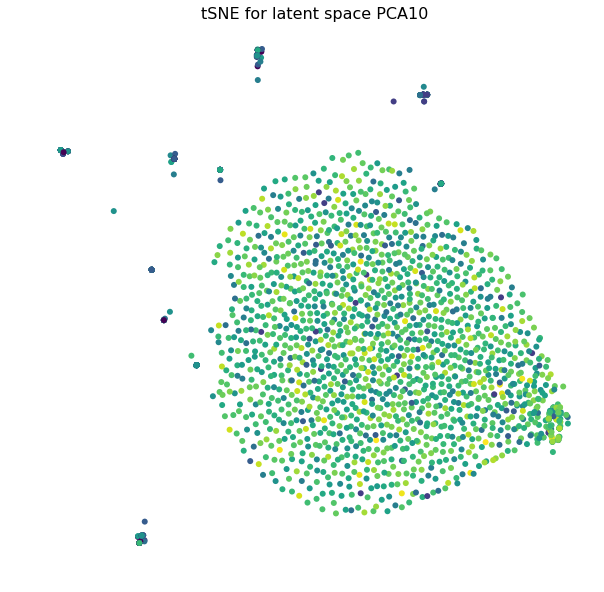

In [18]:
show_tSNE(latent_pc, "PCA10", labels=log_library_size, clusters_cmap=0, cmap="viridis")
plt.savefig("PCA_tSNE_random.pdf", dpi=300)

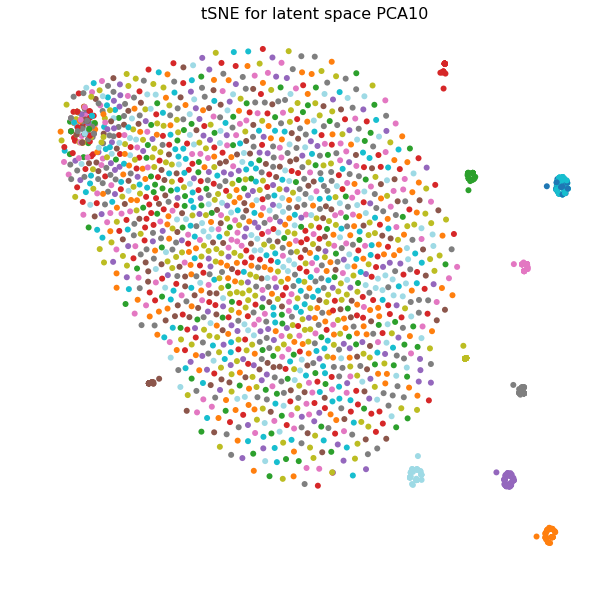

In [17]:
show_tSNE(latent_pc, "PCA10", labels=labels, clusters_cmap=11, cmap="tab20")
plt.savefig("PCA_tSNE_random_SIMLR_labels.pdf", dpi=300)

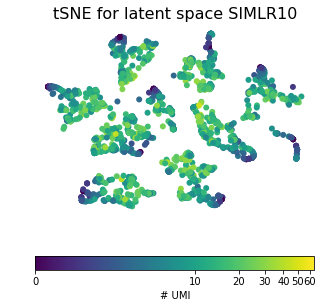

In [25]:
show_tSNE(simlr.ydata,"SIMLR10",  labels=log_library_size, tSNE=False, clusters_cmap=0, cmap="viridis", size=(5, 5))
cbar = plt.colorbar(ticks=np.log(1 + np.array([0, 10, 20, 30, 40, 50, 60])), orientation='horizontal')
cbar.ax.set_xticklabels([0, 10, 20, 30, 40, 50, 60])  # horizontal colorbar
cbar.ax.set_xlabel('# UMI')
plt.savefig("Random_legend.pdf", dpi=300)

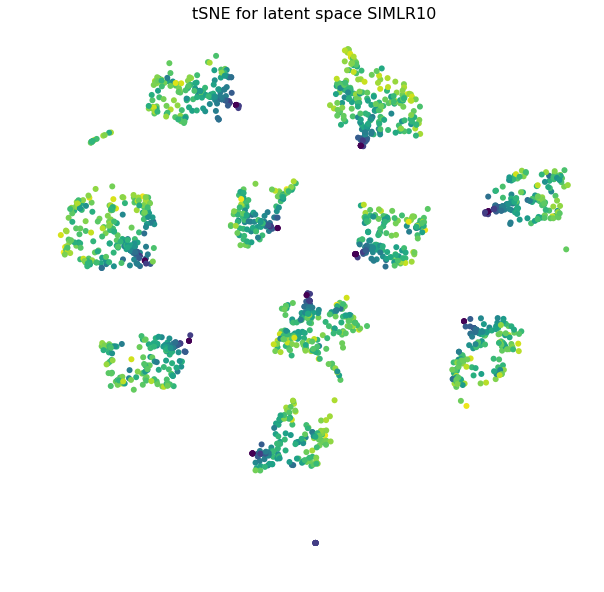

In [19]:
show_tSNE(simlr.ydata,"SIMLR10",  labels=log_library_size, tSNE=False, clusters_cmap=0, cmap="viridis")
plt.savefig("SIMLR_tSNE_random.pdf", dpi=300)

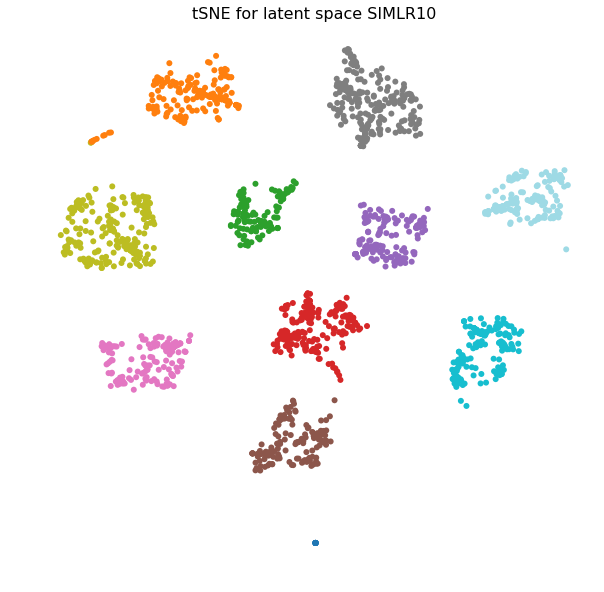

In [21]:
show_tSNE(simlr.ydata,"SIMLR10",  labels=labels, tSNE=False, clusters_cmap=11, cmap="tab20")
plt.savefig("SIMLR_tSNE_random_SIMLR_labels.pdf", dpi=300)

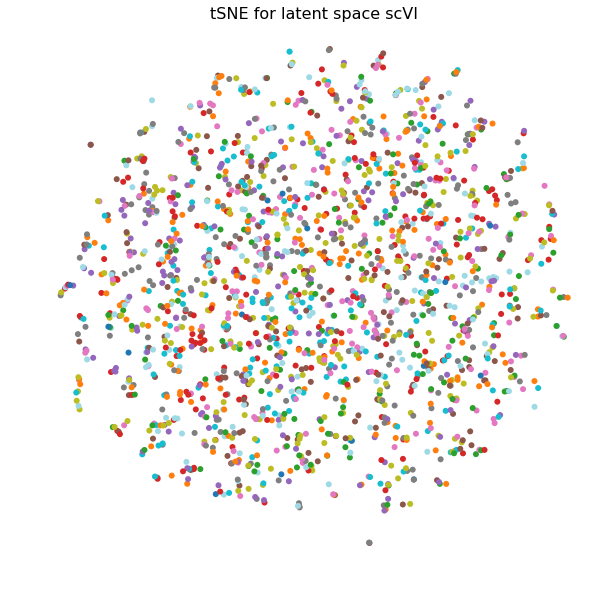

In [22]:
show_tSNE(latent_scVI, "scVI",labels=labels, clusters_cmap=11, cmap="tab20")
plt.savefig("scVI_tSNE_random_SIMLR_labels.pdf", dpi=300)

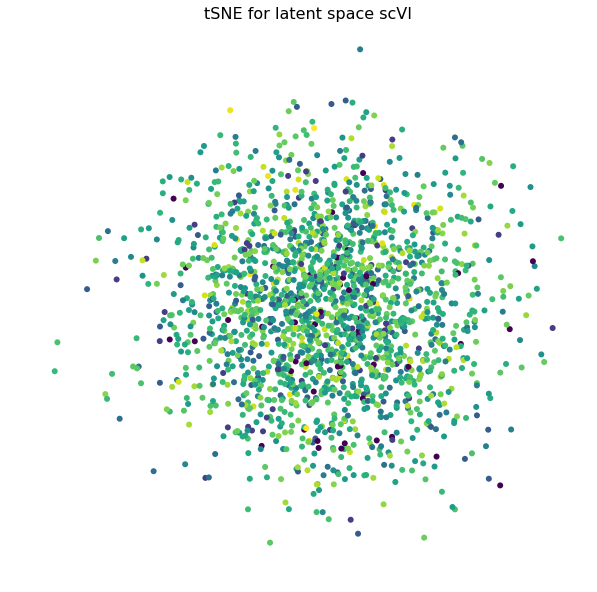

In [23]:
show_tSNE(latent_scVI, "scVI", labels=log_library_size, tSNE=False, clusters_cmap=0, cmap="viridis")
plt.savefig("scVI_tSNE_random.pdf", dpi=300)

### Distance Matrix

In [24]:
from matplotlib import gridspec

In [25]:
def visualize_distance(latent, labels, algorithm):
    order_latent = np.vstack([x for _, x in sorted(zip(labels,latent), key=lambda pair: pair[0])])
    order_label = np.vstack([y for y, x in sorted(zip(labels,latent), key=lambda pair: pair[0])])
    distance = scipy.spatial.distance_matrix(order_latent, order_latent)  
    
    fig = plt.figure(figsize=(10, 10)) 
    gs = gridspec.GridSpec(2, 2, width_ratios=[1, 70], height_ratios=[1, 70])
    gs.update(wspace=0.05, hspace=0.05)
    ax0 = plt.subplot(gs[1])
    ax0.imshow(order_label.T, cmap='Dark2', interpolation='none', aspect=100)
    ax0.axis('off')
    ax1 = plt.subplot(gs[3], sharex=ax0)
    ax1.imshow(distance, cmap='hot', interpolation='none')
    ax1.axis('off')
    ax2 = plt.subplot(gs[2], sharey=ax1)
    ax2.imshow(order_label, cmap='Dark2', interpolation='none', aspect=1/100.)
    ax2.axis('off')
    #plt.tight_layout()
    fig.suptitle("Cell-Cell Similarity matrix on the "+ algorithm + " latent space", fontsize=16, y=0.92)

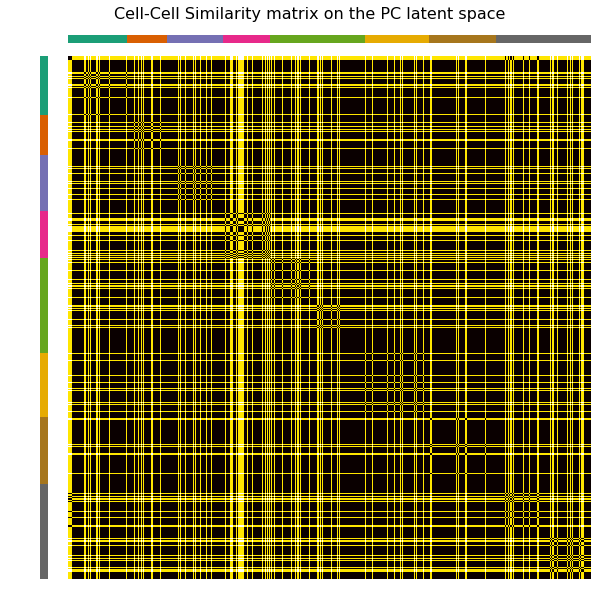

In [26]:
visualize_distance(latent_pc, labels, "PC")
plt.savefig("PCA_distance_random.pdf")

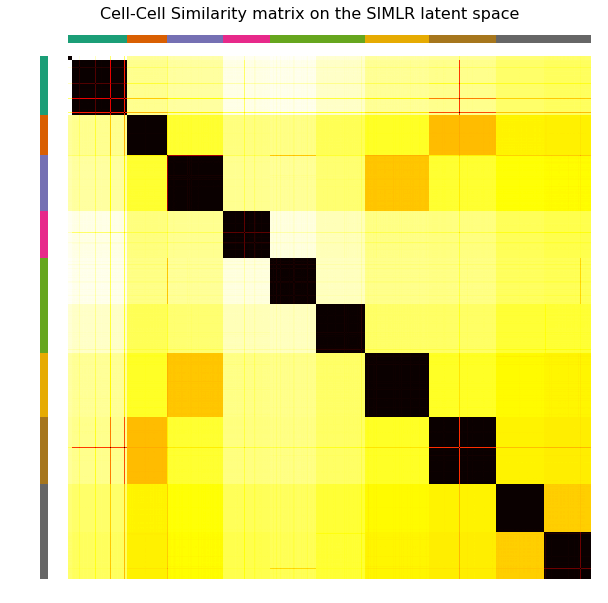

In [27]:
visualize_distance(simlr.F, labels, "SIMLR")
plt.savefig("SIMLR_distance_random.pdf", dpi=300)

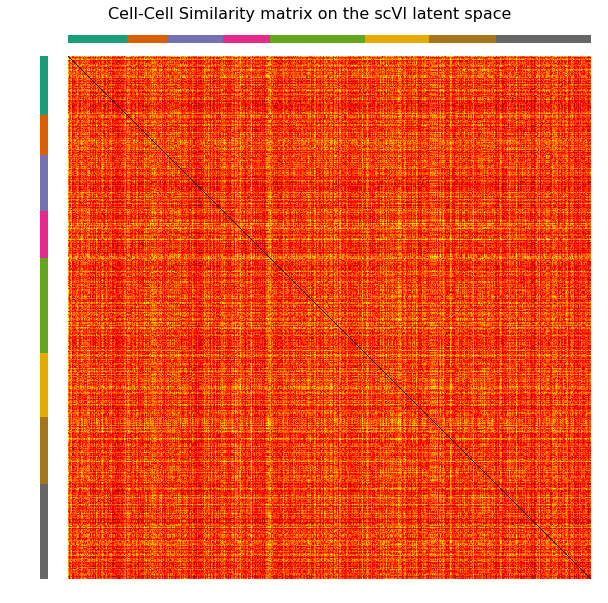

In [28]:
visualize_distance(latent_scVI, labels, "scVI")
plt.savefig("scVI_distance_random.pdf")